In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,3"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# Data Generator

In [3]:
class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, batch_size=8, dim=(256,512), num_regions=20, shuffle=True, num_crops=1):

        self.npz_file_IDs = npz_file_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.num_regions = num_regions
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        local_scene_coords = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        region_labels = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.dim, 1), dtype=np.int16)

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)
            
            images[i] = npz_data['image_colors']
            local_scene_coords[i] = npz_data['local_scene_coords']
            region_labels[i] = np.expand_dims(npz_data['points_region_class'], axis=-1)
            masks[i] = np.expand_dims(npz_data['mask'], axis=-1).astype(int)

        return images, local_scene_coords, region_labels, masks

    
    def crop(self, data, start_row, start_col, data_depth):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        data_croped = np.zeros((self.batch_size, 224, 224, data_depth))

        for ind in range(self.batch_size):

            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_data = data[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                
                data_croped[ind] = np.concatenate(
                    (data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_data), axis=1)
                               
            else:
                data_croped[ind] = data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]

        return data_croped
    
    
    def get_crops(self, images, coords, regions, mask):
        
        # pick the start cordinates of croped images
        start_row = np.random.randint(0, high=self.dim[0]-224, size=self.batch_size)
        start_col = np.random.randint(0, high=self.dim[1], size=self.batch_size)
        
        image_crops = self.crop(images, start_row, start_col, data_depth=3)
        coords_crops = self.crop(coords, start_row, start_col, data_depth=3)
        region_crops = self.crop(regions, start_row, start_col, data_depth=1)
        mask_crops = self.crop(mask, start_row, start_col, data_depth=1)
        
        return image_crops, coords_crops, region_crops, mask_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
     
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

        # load
        images, local_scene_coords, region_labels, masks = self.load_data(list_IDs_temp)

        # crop
        images, local_scene_coords, region_labels, masks = self.get_crops(images, local_scene_coords, region_labels, masks)

        
        # one-hot encode labels
#         region_labels = (np.arange(self.num_regions) == region_labels[:,:,:,0][...,None]).astype(int)


        # expand dimension of mask
        nested_masks = [masks for _ in range(3)]
        mask_expanded = np.concatenate(nested_masks, axis=-1)

        # apply mask to 3D coords ground truth data
        local_scene_coords = local_scene_coords * mask_expanded
                               
        # coccatenate to images
        labels = np.concatenate((local_scene_coords, region_labels), axis=-1)

        return [images, mask_expanded], labels

In [4]:
dataset_size = 370
val_split = 0.1
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/"

data_partition = {'train': [],
                'validation': []}

indexes = np.arange(1,dataset_size + 1)
np.random.shuffle(indexes)
split_index = int(val_split*dataset_size)

for ind in indexes[split_index:]:
    coord_npz = f"{ind:04}_rendered.png_config.npz"
    data_partition['train'].append(data_dir + coord_npz)

for ind in indexes[:split_index]:
    coord_npz = f"{ind:04}_rendered.png_config.npz"
    data_partition['validation'].append(data_dir + coord_npz)

In [5]:
generator_configs = {'batch_size': 10, 
                     'dim': (256,512),
                     'num_regions': 141, 
                     'shuffle': True, 
                     'num_crops': 1}

# data_partition = ["/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_96_classes/0001_rendered.png_config.npz"]

train_generator = DataGenerator(data_partition['train'], **generator_configs)

# Model

In [6]:
from tensorflow.keras import layers

def vgg_encoder(input_shape=(224, 224, 3)):
    
    image_input = layers.Input(shape=(224, 224, 3))

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    f3 = x

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    f4 = x

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    f5 = x
    
    return image_input, [f1,f2,f3,f4,f5]

In [7]:
from tensorflow.keras.models import Model

def vgg_unet(num_regions, input_height=224, input_width=224):

    model = unet(vgg_encoder, num_regions, input_height=input_height, input_width=input_width)
    model.model_name = "vgg_unet"
    
    return model


def unet(encoder, num_regions, l1_skip_conn=True, input_height=224,
          input_width=224):

    image_input = layers.Input(shape=(224, 224, 3))
    mask = layers.Input(shape=(224, 224, 3))
    
    image_input, levels = encoder(image_input)
    [f1, f2, f3, f4, f5] = levels

    o = f4
    o = (layers.ZeroPadding2D((1, 1), name='U_block1_zero_pad'))(o)
    o = (layers.Conv2D(512, (3, 3), padding='valid' , activation='relu', name='U_block1_conv'))(o)
    o = (layers.BatchNormalization(name='U_block1_batch_norm'))(o)

    o = (layers.UpSampling2D((2, 2), name='U_block2_up_sample'))(o)
    o = (layers.concatenate([o, f3], axis=-1, name='U_block2_concat'))
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(512, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = (layers.UpSampling2D((2, 2)))(o)
    o = (layers.concatenate([o, f2], axis=-1))
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(256, (3, 3), padding='valid' , activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = (layers.UpSampling2D((2, 2)))(o)

    if l1_skip_conn:
        o = (layers.concatenate([o, f1], axis=-1))

    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)

    o = layers.Conv2D(128, (3, 3), padding='same')(o)
    
    o = (layers.UpSampling2D((2, 2)))(o)
    o = (layers.ZeroPadding2D((1, 1)))(o)
    o = (layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))(o)
    o = (layers.BatchNormalization())(o)
    

    
    # REGRESSION
    o_regr = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(o)
    output_reg = layers.Conv2D(3, (3, 3), padding='same')(o_regr)
    output_masked_reg = layers.Multiply()([output_reg, mask])

    
    # CLASSIFICATION
    o_clas = layers.Conv2D(num_regions, (3, 3), padding='same')(o)
    output_clas = keras.activations.softmax(o_clas, axis=-1)
    
    
    # CONCATENATE
    output = layers.Concatenate(axis=-1)([output_masked_reg, output_clas])
    
    
    model = Model(inputs=[image_input, mask], outputs=output) 
#     model.summary()
    
    return model

# Loss func

In [8]:
def combined_loss(y_true, y_pred):
    " combined loss for 3D local coordinate regression and Classification"

    beta = 0.5
    
    regr_true = y_true[:,:,:,:3]
    clas_true = y_true[:,:,:,3:]    
    regr_pred = y_pred[:,:,:,:3]
    clas_pred = y_pred[:,:,:,3:]

    regr_loss = tf.keras.losses.mean_squared_error(regr_true, regr_pred)
    regr_loss = tf.reduce_mean(regr_loss)

#     clas_loss = tf.keras.losses.categorical_crossentropy(clas_true, clas_pred)  # 1-hot-encoded labels
    clas_loss = tf.keras.losses.sparse_categorical_crossentropy(clas_true, clas_pred)  # categorical labels 
    clas_loss = tf.reduce_mean(clas_loss)
    
    loss = 1*regr_loss + 1*clas_loss
    return loss

# Setup model

In [9]:
# # Example model
# unet_model = vgg_unet(num_regions=96)
# unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss)

# Fit model

In [10]:
[images, mask], labels = train_generator.__getitem__(0)

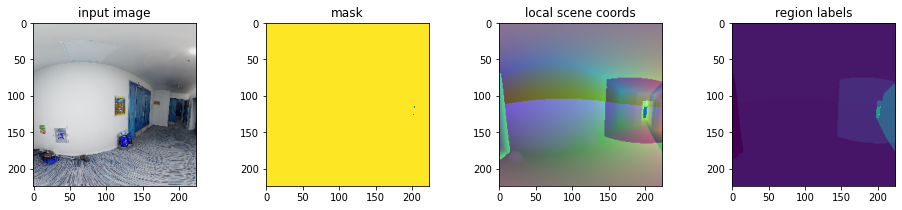

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

# only use two lines below if input is unnormalised
local_coords_norm = (labels[0,:,:,:3] - labels[0,:,:,:3].min()) / (labels[0,:,:,:3].max() - labels[0,:,:,:3].min())
# labels[0,:,:,:3] = local_coords_norm * mask[0]

ax3.imshow(local_coords_norm)
ax3.set_title("local scene coords")

# ax4.imshow(np.argmax(labels[0,:,:,3:], axis=-1))
ax4.imshow(labels[0,:,:,3:])
ax4.set_title("region labels")
plt.show()

**Note:** you can see mask on visualisation of local scene coords. The mask has been already applied in the data generator. In prediction visualisation mask will also have been applied in the network.

**Note2:** it is VERY IMPORTANT to have normalised labels. Otherwise it is harder to optimise the model (i wasn't able to train it).

In [19]:
fit_configs = {'epochs': 20, 
               'verbose': 1}

strategy = tf.distribute.MirroredStrategy(['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    
    # data gen
    train_generator = DataGenerator(data_partition['train'], **generator_configs)
    
    # Example model
    unet_model = vgg_unet(num_regions=141)
    unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss)

    history = unet_model.fit(x=train_generator,  **fit_configs) #, callbacks=callback
    # history = unet_model.fit([images, mask], labels,  **fit_configs) #, callbacks=callback

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1
16/33 [=============>................] - ETA: 3s - loss: 6.4630

KeyboardInterrupt: 

# Evaluate model

In [ ]:
label_pred = unet_model.predict([images, mask])

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

tmp = (label_pred[0,:,:,:3] - label_pred[0,:,:,:3].min()) / (label_pred[0,:,:,:3].max() - label_pred[0,:,:,:3].min())
ax3.imshow(tmp)
ax3.set_title("local scene coords (normalised)")

ax4.imshow(np.argmax(label_pred[0,:,:,3:], axis=-1))
ax4.set_title("region labels")
plt.show()

In [ ]:
# visualise distribution of TRUE and PRED
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))

ax1.hist(np.reshape(label_pred[0,:,:,:3], (-1)), label="pred", alpha=0.3)
ax1.hist(np.reshape(labels[0,:,:,:3], (-1)), label="true", alpha=0.3)
ax1.legend()

ax2.hist(np.reshape(np.argmax(label_pred[0,:,:,3:], axis=-1), (-1)), label="pred", alpha=0.3, bins=20)
# ax2.hist(np.reshape(np.argmax(labels[0,:,:,3:], axis=-1), (-1)), label="true", alpha=0.3)
ax2.hist(np.reshape(labels[0,:,:,3:], (-1)), label="true", alpha=0.3, bins=20)
ax2.legend()
plt.show()

# Unwhiten predicted coordinates

# Predict pose

# Debugging code

### getting outputs of individual layers

In [ ]:
extractor = keras.Model(inputs=unet_model.inputs,
                        outputs=[unet_model.output for layer in unet_model.layers])

In [ ]:
output = extractor(images)
output[-1].numpy()[0,0,0,:]

### test loss function utside of NN

In [55]:
gen_mask_ = np.expand_dims(gen_mask, axis=-1)
gen_mask_.shape

(1, 224, 224, 1)

In [71]:
labels_pred = np.zeros((1,224,224,8))
labels_pred[:,:,:,:] = 1/8

labels_true = np.zeros((1,224,224,8))
labels_true[:,:,:,0] = 1
# mask = np.ones((1,224,224,1))
labels_true = np.concatenate([labels_true, gen_mask_], axis=-1)
labels_true.shape

(1, 224, 224, 9)

In [72]:
a = masked_X_entropy(labels_true, labels_pred)
a.numpy()

tf.Tensor(
[[[2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  ...
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]]], shape=(1, 224, 224), dtype=float64)


array([[[2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        ...,
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154]]])

In [73]:
np.unique(a.numpy())

array([0.        , 2.07944154])

(array([2.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0152e+04]),
 array([0.        , 0.20794415, 0.41588831, 0.62383246, 0.83177662,
        1.03972077, 1.24766493, 1.45560908, 1.66355323, 1.87149739,
        2.07944154]),
 <BarContainer object of 10 artists>)

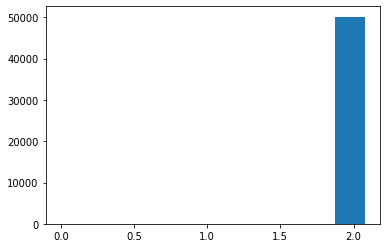

In [74]:
plt.hist(a.numpy().flatten())

In [18]:
tf.keras.losses.categorical_crossentropy(labels_pred, labels_true[:,:,:,:8])

<tf.Tensor: shape=(1, 224, 224), dtype=float64, numpy=
array([[[14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        ...,
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371]]])>

## $\color{red}{\text{CONCLUSION:}}$
### there were 3 errors:

**1. cross entropy outputed 2D matrix rather than scalar** Loss in general should be a scalar. If it's a vector you might compute an update with respect to each element of loss which could grow quicker than for a mean. There would be batch_size*224*224 updates

**2. I was applying softmax function twice** After deleting the first softmax model was fixed. The first softmax could be applied for all nodes 224x224x8 rather than just along the axis=-1

**3. there is some issue with the way i apply the mask** 